In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
path = '/kaggle/input/chess-pieces-detection-images-dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))

In [5]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path          Labels
0  /kaggle/input/chess-pieces-detection-images-da...    pawn_resized
1  /kaggle/input/chess-pieces-detection-images-da...  bishop_resized
2  /kaggle/input/chess-pieces-detection-images-da...   knight-resize
3  /kaggle/input/chess-pieces-detection-images-da...  bishop_resized
4  /kaggle/input/chess-pieces-detection-images-da...    pawn_resized

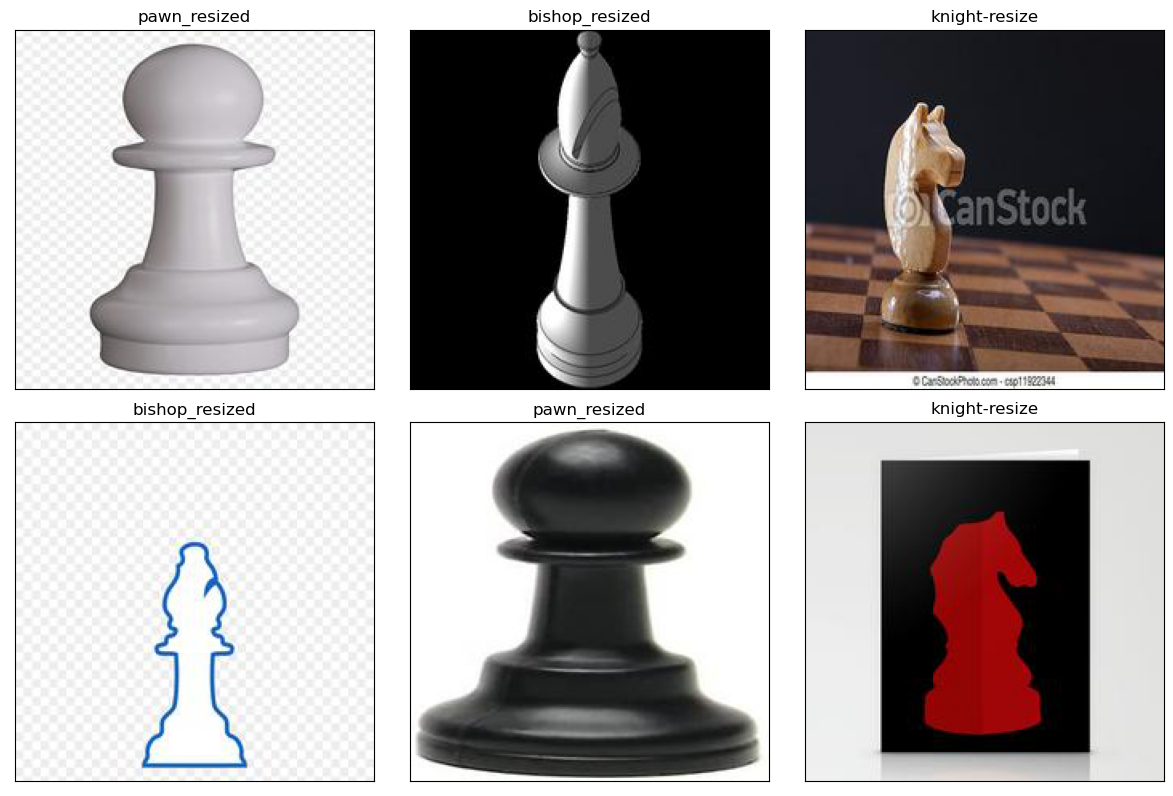

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

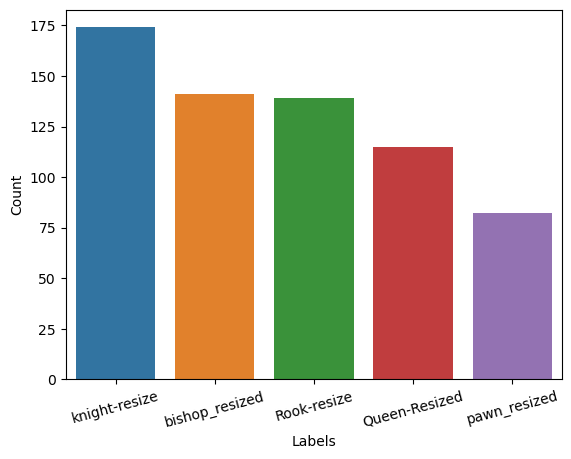

In [7]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=15);

In [8]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

In [9]:
def func(pre,name_model,size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    
    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

# Training Models

# **Inception V3**

#####~Model => <function InceptionV3 at 0x7fb1f0b23e60> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
87910968/87910968 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


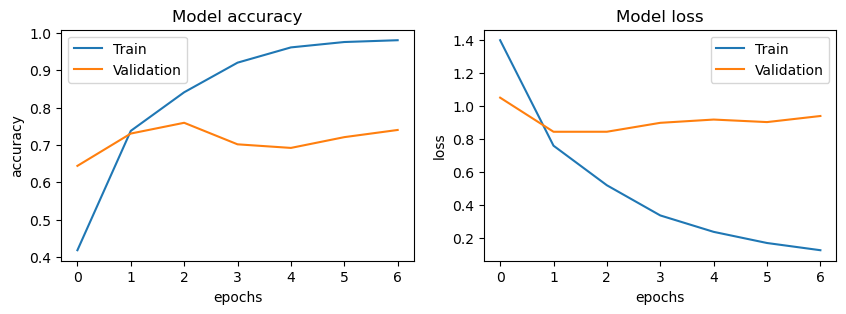

5/5 [==============================] - 3s 328ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.53      0.50      0.51        18
   Rook-resize       0.61      0.81      0.69        21
bishop_resized       0.58      0.69      0.63        32
 knight-resize       0.90      0.88      0.89        42
  pawn_resized       0.86      0.33      0.48        18

      accuracy                           0.69       131
     macro avg       0.70      0.64      0.64       131
  weighted avg       0.72      0.69      0.69       131

 Display 6 pictures of the dataset with their labels 


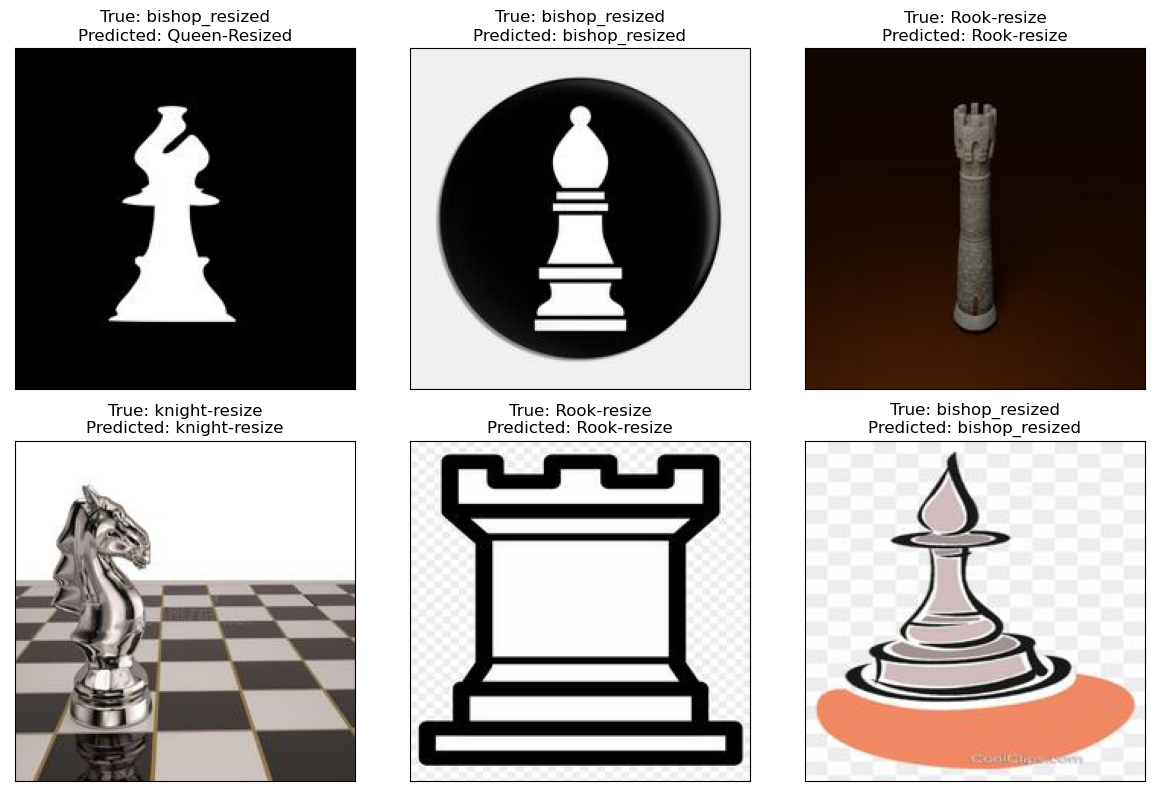

              Results 
    Test Loss:  0.98235  
Test Accuracy:  69.47%  


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = func(preprocess_input,InceptionV3,100)

# **NasNetLarge**

#####~Model => <function NASNetLarge at 0x7fb1f0b37dd0> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
343610240/343610240 [==============================] - 3s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


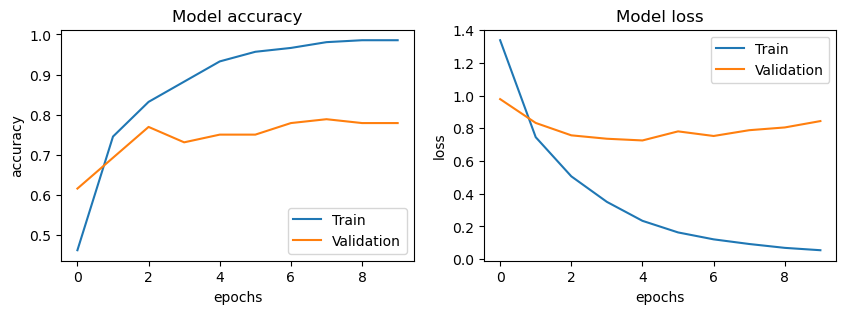

5/5 [==============================] - 12s 1s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.69      0.61      0.65        18
   Rook-resize       0.82      0.86      0.84        21
bishop_resized       0.66      0.72      0.69        32
 knight-resize       0.97      0.83      0.90        42
  pawn_resized       0.55      0.67      0.60        18

      accuracy                           0.76       131
     macro avg       0.74      0.74      0.73       131
  weighted avg       0.77      0.76      0.76       131

 Display 6 pictures of the dataset with their labels 


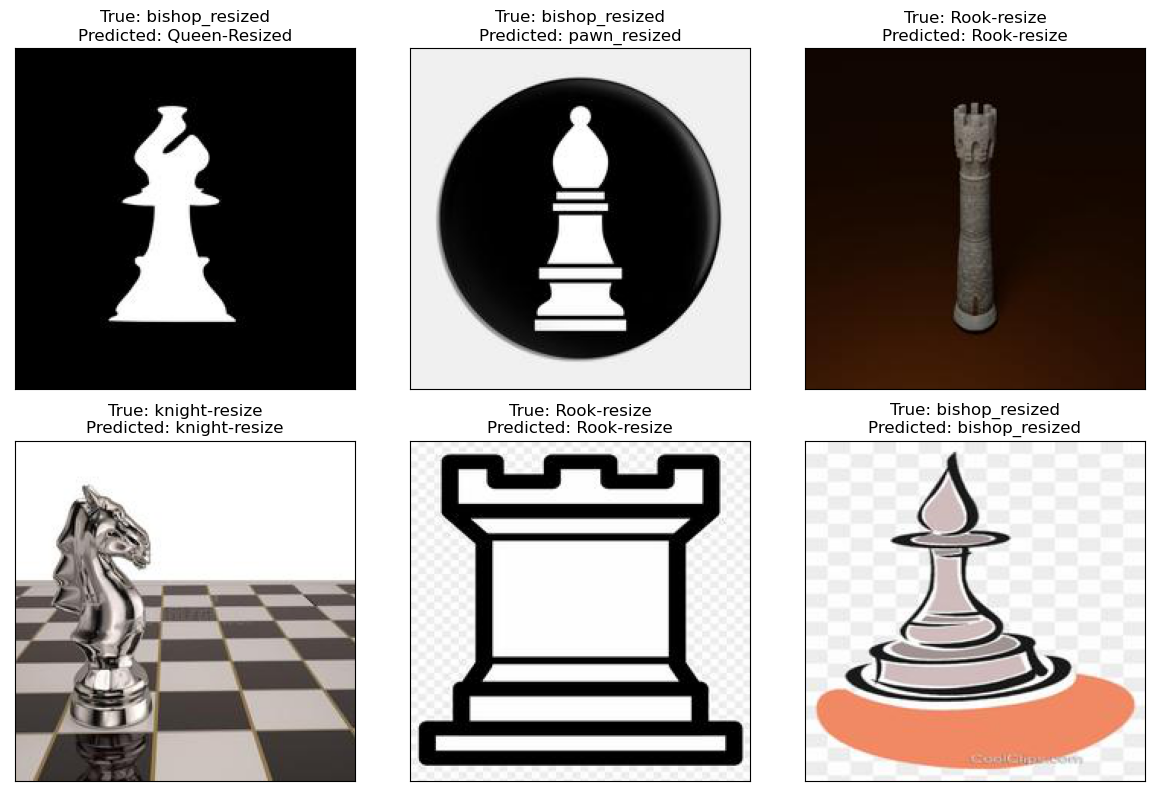

              Results 
    Test Loss:  0.67339  
Test Accuracy:  75.57%  


In [11]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
result_NASNetLarge = func(preprocess_input,NASNetLarge,331)

# **NasNetMobile**

#####~Model => <function NASNetMobile at 0x7fb1f0b37d40> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
19993432/19993432 [==============================] - 0s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


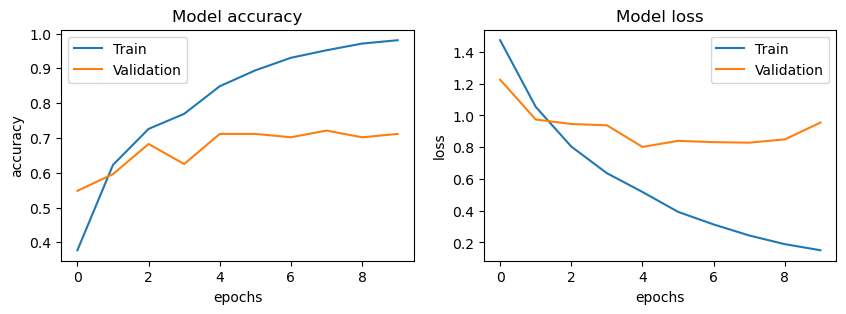

5/5 [==============================] - 5s 155ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.82      0.50      0.62        18
   Rook-resize       0.69      0.86      0.77        21
bishop_resized       0.65      0.88      0.75        32
 knight-resize       0.86      0.88      0.87        42
  pawn_resized       0.88      0.39      0.54        18

      accuracy                           0.76       131
     macro avg       0.78      0.70      0.71       131
  weighted avg       0.78      0.76      0.74       131

 Display 6 pictures of the dataset with their labels 


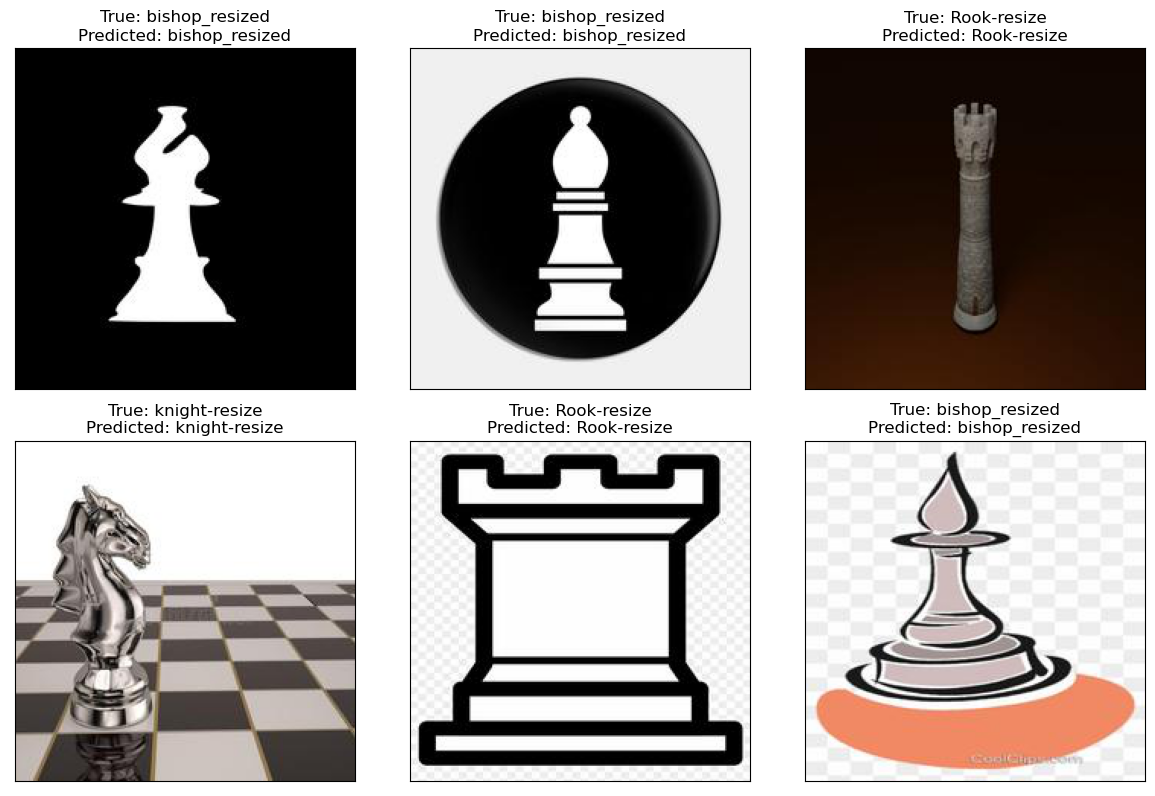

              Results 
    Test Loss:  0.90317  
Test Accuracy:  75.57%  


In [12]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
result_NASNetMobile = func(preprocess_input,NASNetMobile,224)

# **InceptionResNetV2**

#####~Model => <function InceptionResNetV2 at 0x7fb1f0b23710> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
219055592/219055592 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


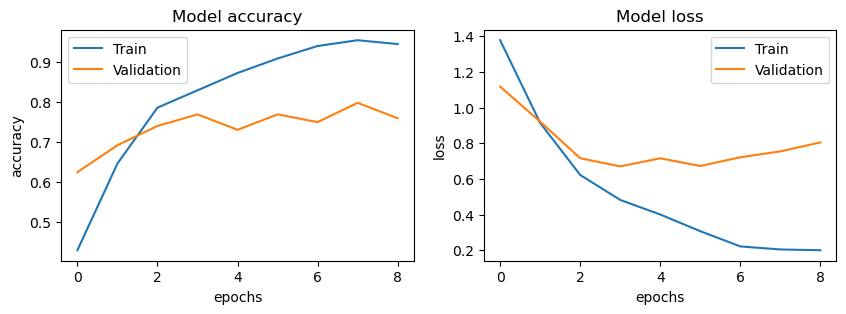

5/5 [==============================] - 5s 361ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.67      0.11      0.19        18
   Rook-resize       0.76      0.90      0.83        21
bishop_resized       0.60      0.91      0.72        32
 knight-resize       1.00      0.90      0.95        42
  pawn_resized       0.65      0.61      0.63        18

      accuracy                           0.76       131
     macro avg       0.74      0.69      0.66       131
  weighted avg       0.77      0.76      0.73       131

 Display 6 pictures of the dataset with their labels 


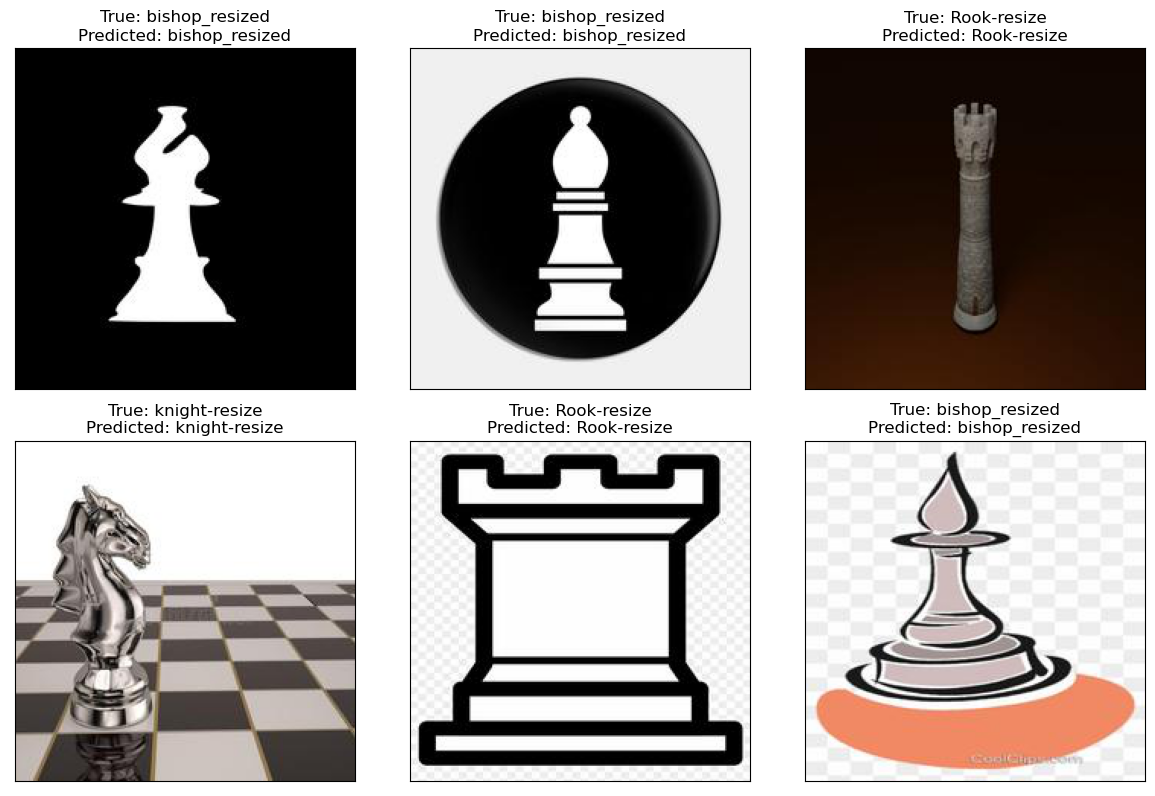

              Results 
    Test Loss:  0.71510  
Test Accuracy:  75.57%  


In [13]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InceptionResNetV2 = func(preprocess_input,InceptionResNetV2,224)

# **DenseNet201**

#####~Model => <function DenseNet201 at 0x7fb1f0b8af80> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
74836368/74836368 [==============================] - 2s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


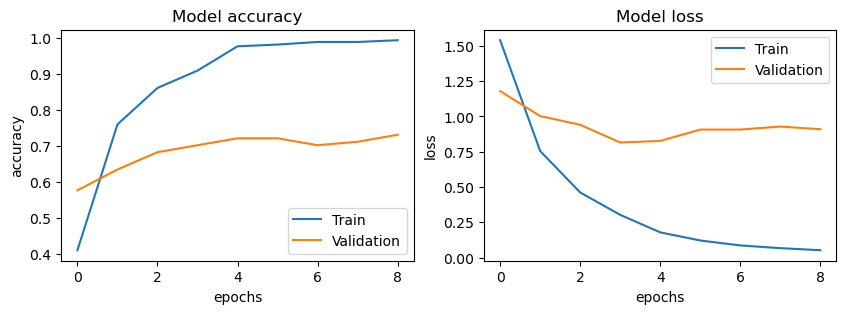

5/5 [==============================] - 5s 431ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.63      0.67      0.65        18
   Rook-resize       0.82      0.86      0.84        21
bishop_resized       0.79      0.72      0.75        32
 knight-resize       0.93      0.95      0.94        42
  pawn_resized       0.67      0.67      0.67        18

      accuracy                           0.80       131
     macro avg       0.77      0.77      0.77       131
  weighted avg       0.80      0.80      0.80       131

 Display 6 pictures of the dataset with their labels 


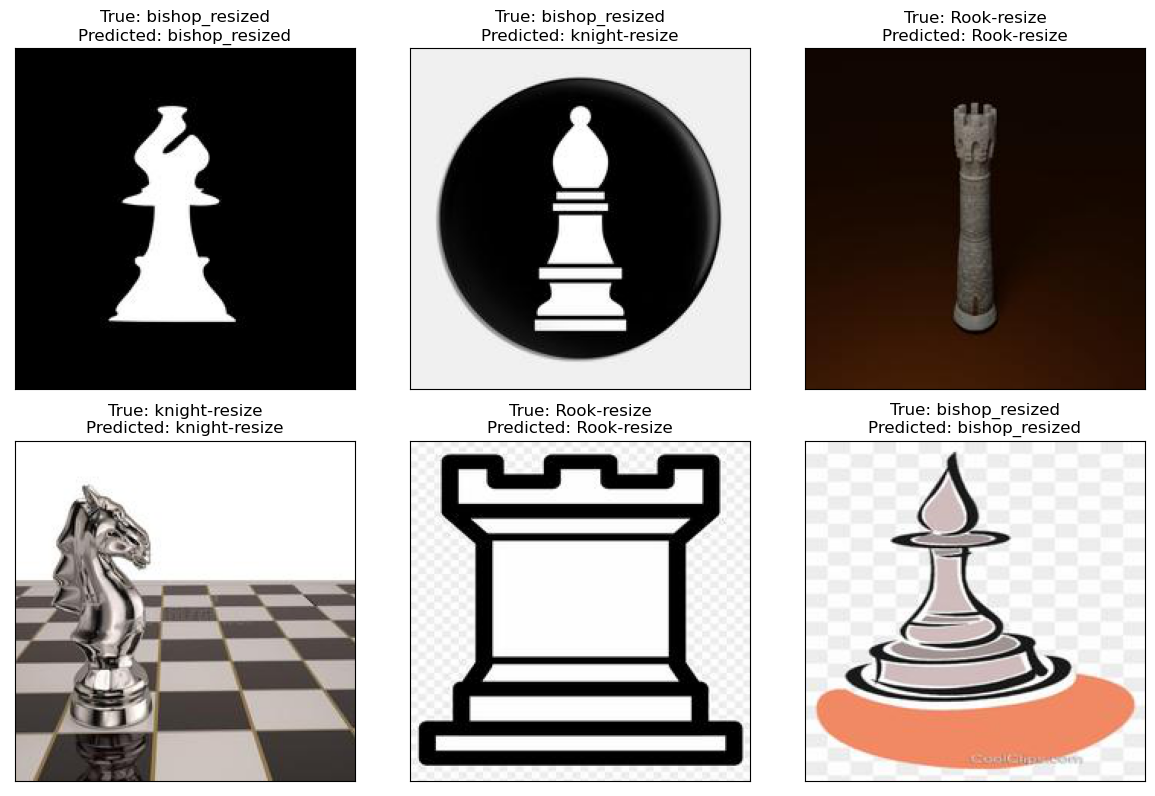

              Results 
    Test Loss:  0.89827  
Test Accuracy:  80.15%  


In [14]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = func(preprocess_input,DenseNet201,100)

# **EfficientNetB7**

#####~Model => <function EfficientNetB7 at 0x7fb1f0b8bf80> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
258076736/258076736 [==============================] - 2s 0us/step


2023-04-25 10:11:26.917671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


              Plotting Accuracy, val_accuracy, loss, val_loss 


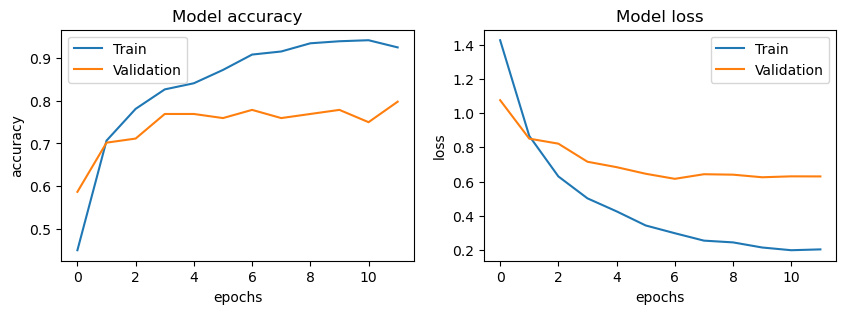

5/5 [==============================] - 7s 381ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.65      0.61      0.63        18
   Rook-resize       0.86      0.86      0.86        21
bishop_resized       0.76      0.81      0.79        32
 knight-resize       0.86      0.90      0.88        42
  pawn_resized       0.80      0.67      0.73        18

      accuracy                           0.80       131
     macro avg       0.79      0.77      0.78       131
  weighted avg       0.80      0.80      0.80       131

 Display 6 pictures of the dataset with their labels 


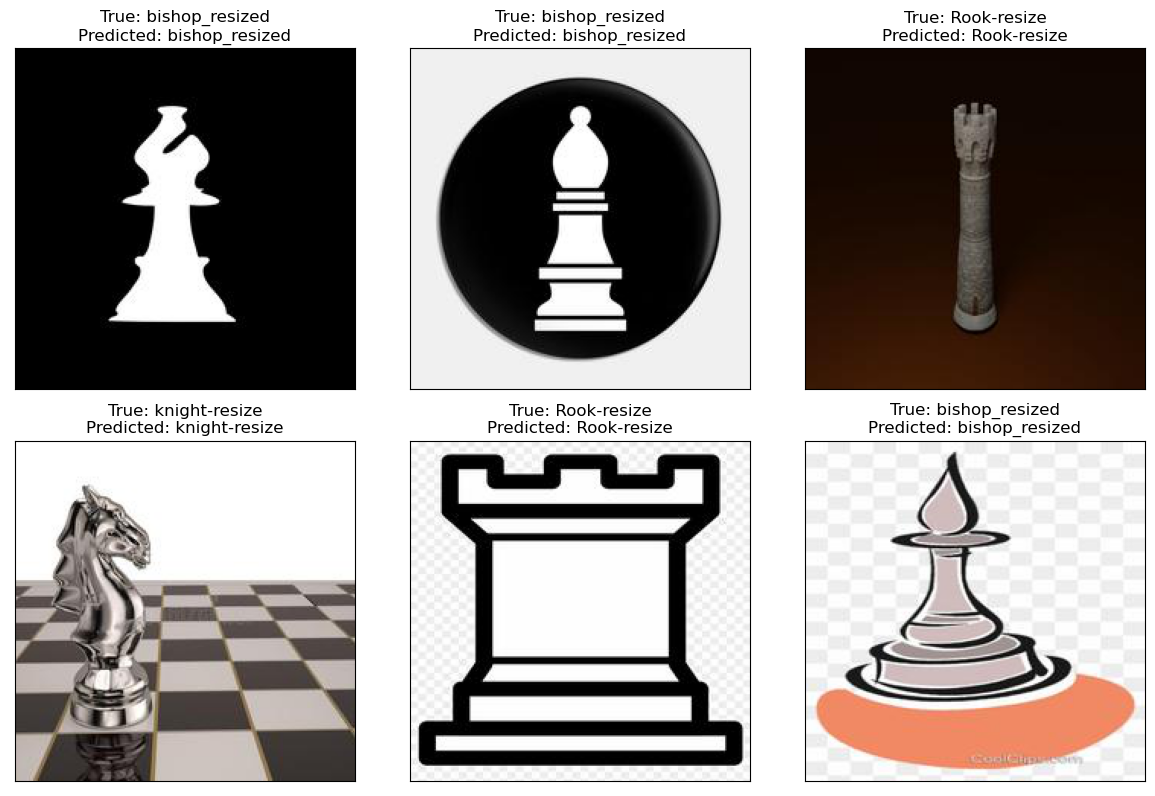

              Results 
    Test Loss:  0.60903  
Test Accuracy:  80.15%  


In [15]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
result_EfficientNetB7 = func(preprocess_input,EfficientNetB7,100)

# **ResNet50**

#####~Model => <function ResNet50 at 0x7fb1f0b47200> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
94765736/94765736 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


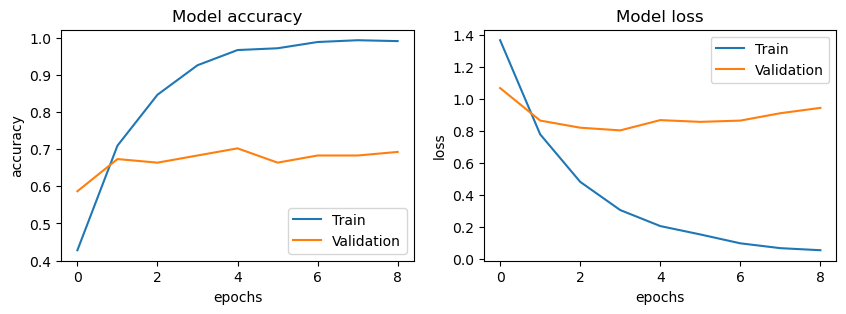

5/5 [==============================] - 2s 146ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.52      0.61      0.56        18
   Rook-resize       0.68      0.81      0.74        21
bishop_resized       0.66      0.59      0.62        32
 knight-resize       0.86      0.76      0.81        42
  pawn_resized       0.53      0.56      0.54        18

      accuracy                           0.68       131
     macro avg       0.65      0.67      0.66       131
  weighted avg       0.69      0.68      0.68       131

 Display 6 pictures of the dataset with their labels 


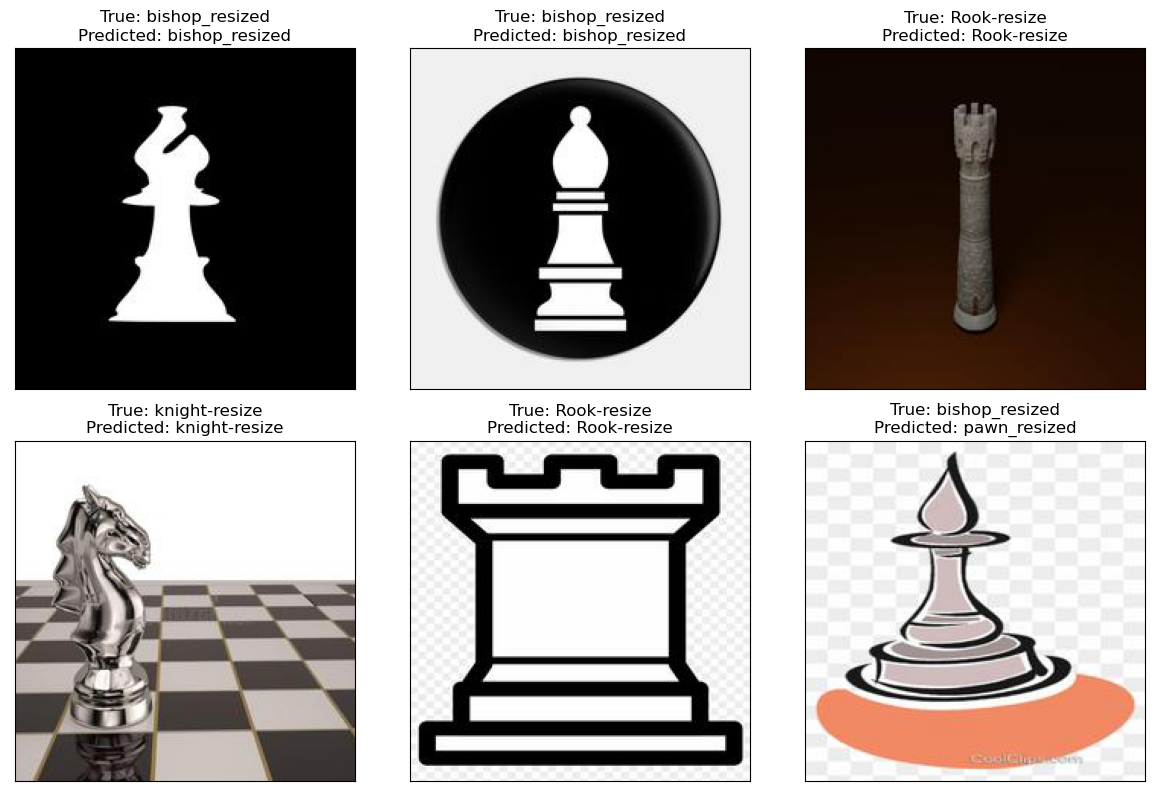

              Results 
    Test Loss:  1.07458  
Test Accuracy:  67.94%  


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet50 = func(preprocess_input,ResNet50,100)

# **ResNet152**

#####~Model => <function ResNet152 at 0x7fb1f0b47320> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
234698864/234698864 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


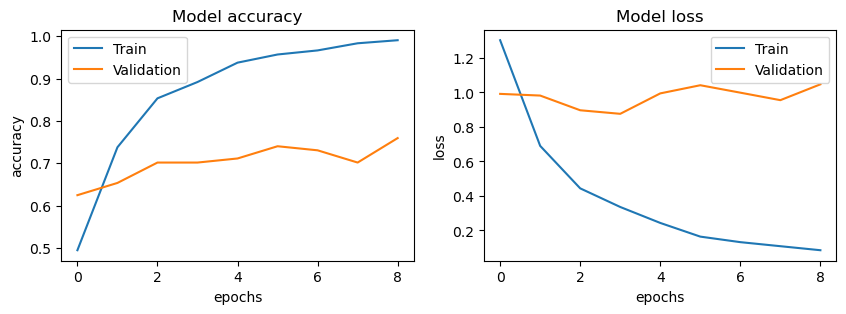

5/5 [==============================] - 3s 100ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.46      0.61      0.52        18
   Rook-resize       0.81      0.62      0.70        21
bishop_resized       0.60      0.75      0.67        32
 knight-resize       0.91      0.93      0.92        42
  pawn_resized       0.75      0.33      0.46        18

      accuracy                           0.71       131
     macro avg       0.71      0.65      0.65       131
  weighted avg       0.73      0.71      0.71       131

 Display 6 pictures of the dataset with their labels 


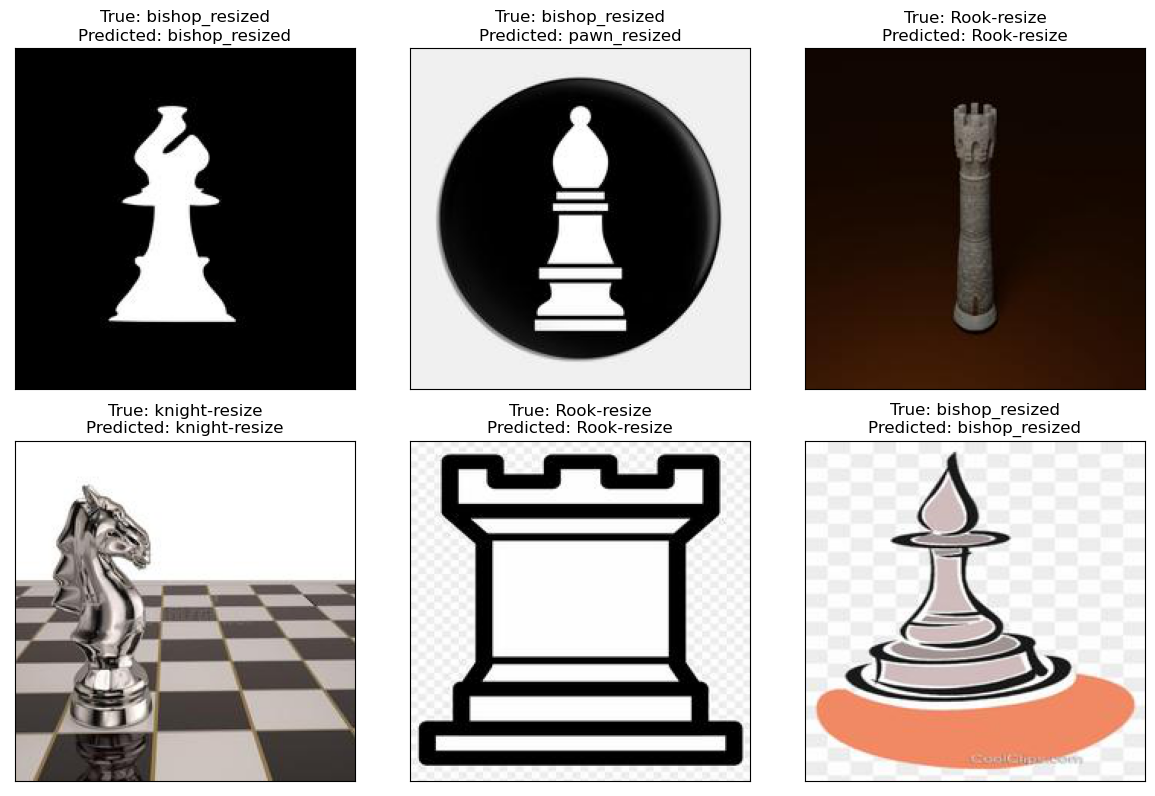

              Results 
    Test Loss:  1.13628  
Test Accuracy:  70.99%  


In [17]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet152 = func(preprocess_input,ResNet152,100)

# **MobileNetV2**

#####~Model => <function MobileNetV2 at 0x7fb1f0b27a70> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
9406464/9406464 [==============================] - 0s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


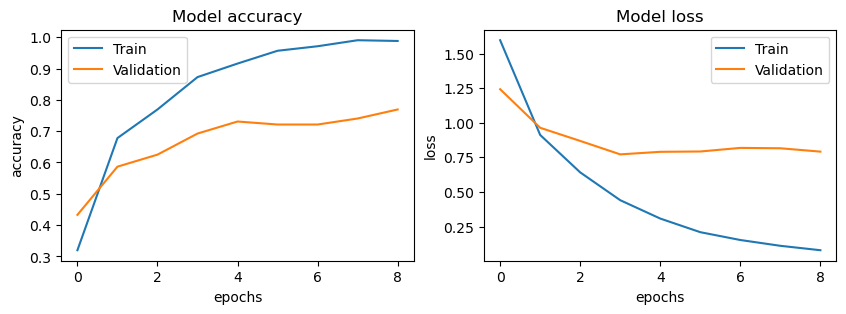

5/5 [==============================] - 1s 122ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.56      0.56      0.56        18
   Rook-resize       0.78      0.86      0.82        21
bishop_resized       0.61      0.62      0.62        32
 knight-resize       0.83      0.93      0.88        42
  pawn_resized       0.80      0.44      0.57        18

      accuracy                           0.73       131
     macro avg       0.71      0.68      0.69       131
  weighted avg       0.73      0.73      0.72       131

 Display 6 pictures of the dataset with their labels 


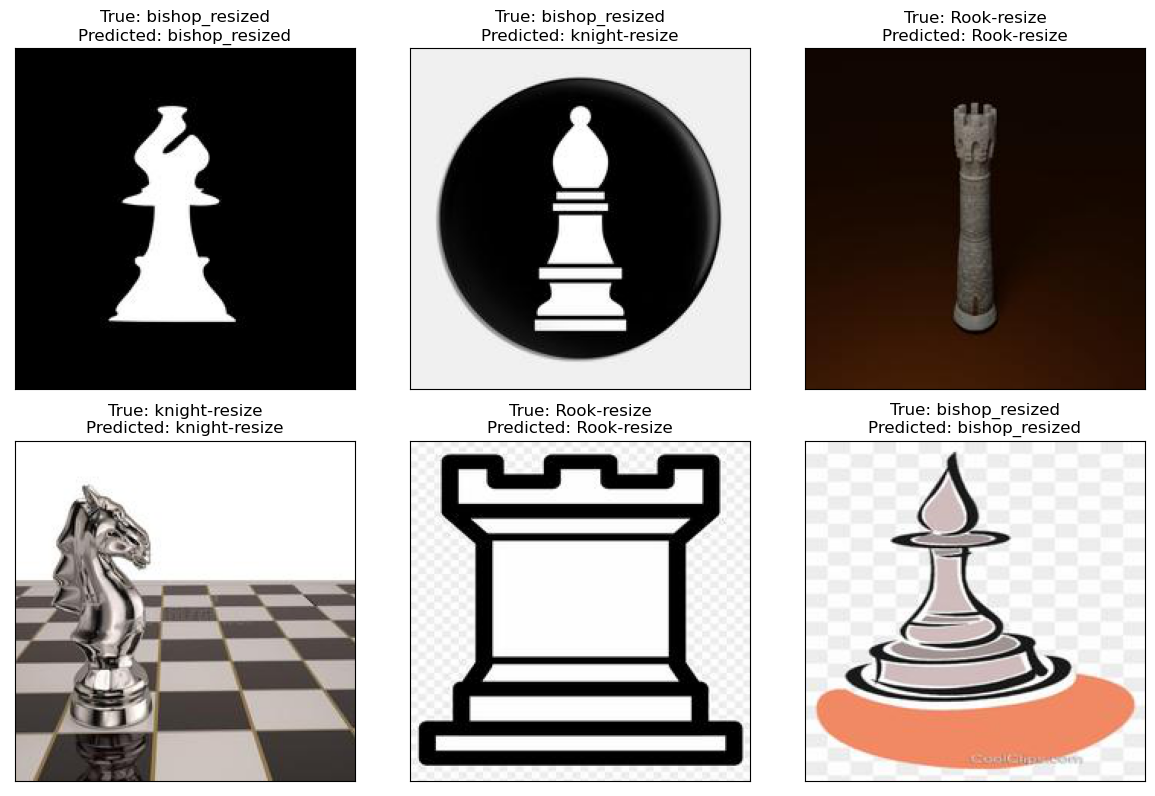

              Results 
    Test Loss:  1.00535  
Test Accuracy:  72.52%  


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
result_MobileNetV2 = func(preprocess_input,MobileNetV2,100)

# **ResNet101V2**

#####~Model => <function ResNet101V2 at 0x7fb1f0b54050> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
171317808/171317808 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


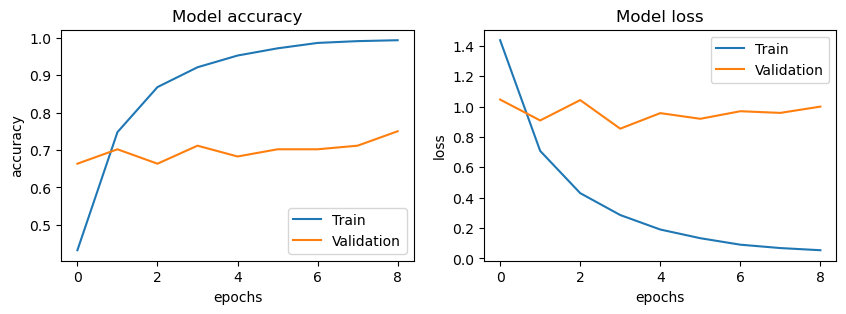

5/5 [==============================] - 3s 156ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.46      0.67      0.55        18
   Rook-resize       0.54      0.62      0.58        21
bishop_resized       0.62      0.47      0.54        32
 knight-resize       0.93      0.88      0.90        42
  pawn_resized       0.59      0.56      0.57        18

      accuracy                           0.66       131
     macro avg       0.63      0.64      0.63       131
  weighted avg       0.68      0.66      0.67       131

 Display 6 pictures of the dataset with their labels 


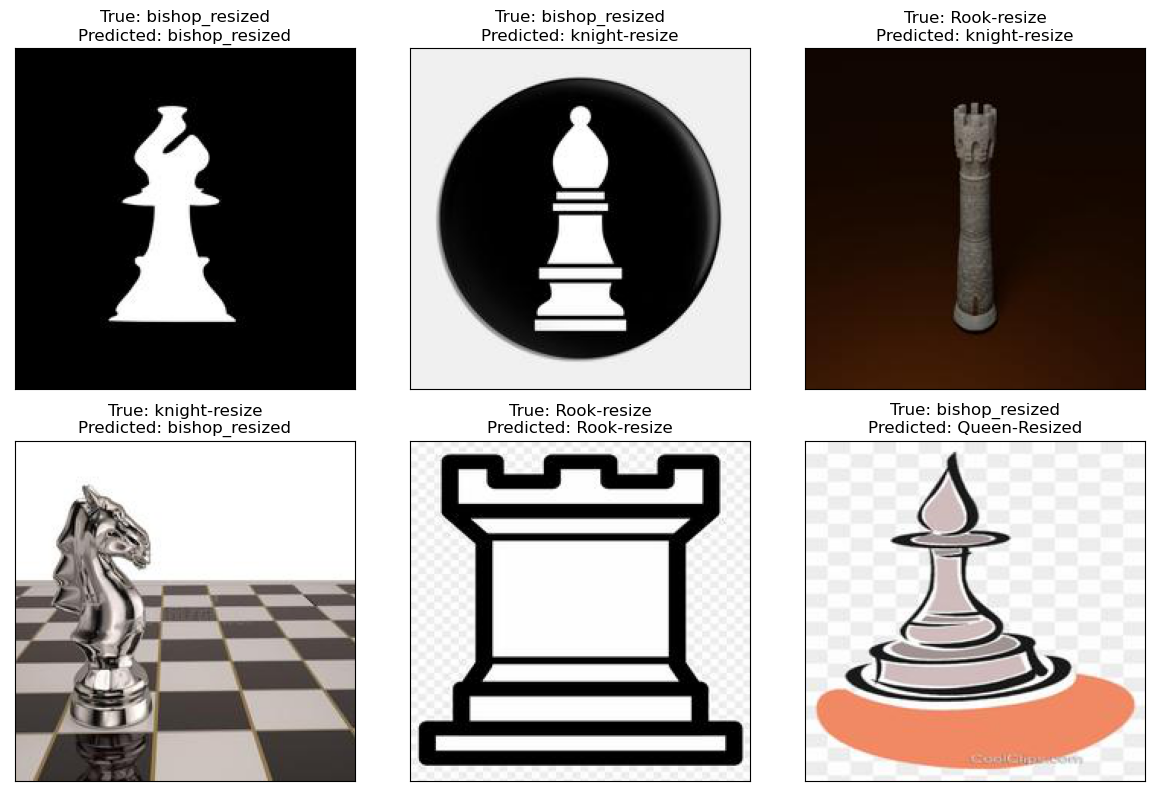

              Results 
    Test Loss:  1.34684  
Test Accuracy:  66.41%  


In [19]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
result_ResNet101V2 = func(preprocess_input,ResNet101V2,100)

# **Final Report**

In [20]:
output = pd.DataFrame({'Model':['InceptionV3','NASNetLarge','NASNetMobile','InceptionResNetV2',
                                'DenseNet201','EfficientNetB7','ResNet50','ResNet152 ','MobileNetV2 ','ResNet101V2'],
                      'Accuracy':[result_InceptionV3[1], result_NASNetLarge[1], result_NASNetMobile[1], result_InceptionResNetV2[1],
                                  result_DenseNet201[1],result_EfficientNetB7[1],result_ResNet50[1],
                                 result_ResNet152[1],result_MobileNetV2[1],result_ResNet101V2[1]]})

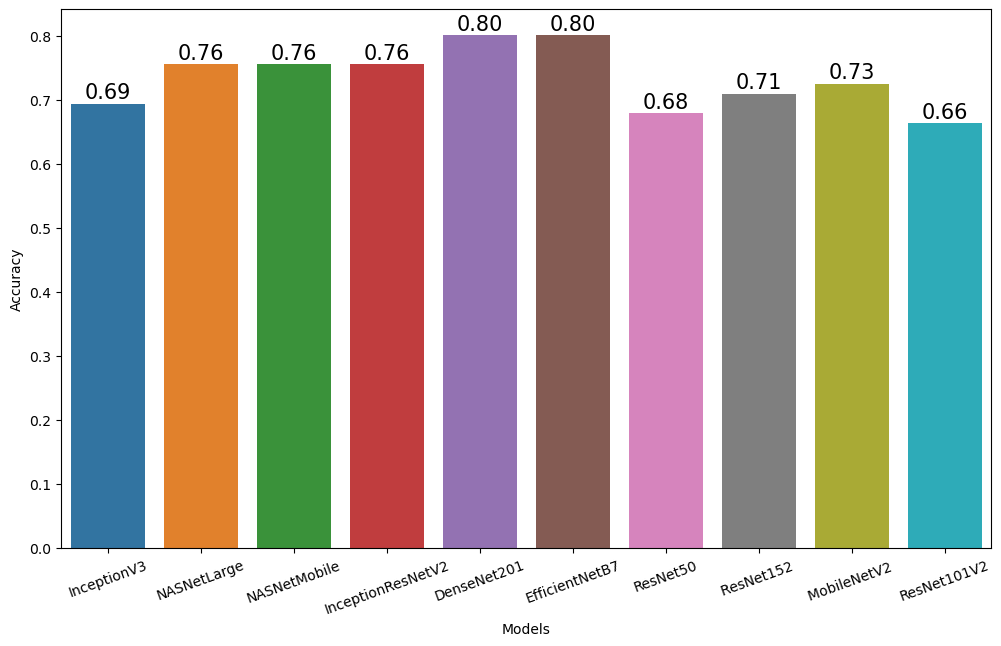

In [21]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);